In [141]:
import os
import sys

import numpy as np

import paths
import pickle
import importlib

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from streamfunction_ecco import streamfunction_custom_utils as strf_utils

import matplotlib.pyplot as plt

In [97]:
data_home = paths.LOCAL_DIR
lats = [26, -30, -55, -60]

#### A. COLLECT THE NEEDED DATA

1. Prepare the RAPID streamfunction in the correct format

In [362]:
def format_RAPID(RAPID_path):
    
    PSI_RAPID = xr.open_dataset(os.path.join(paths.RAPID_ARRAY, "moc_vertical.nc"))

    PSI_RAPID['depth'] = - PSI_RAPID['depth']
    PSI_RAPID = (PSI_RAPID
                 .rename({'depth': 'Z'})
                 .rename_vars({'stream_function_mar': 'psi_moc'})
                 .assign_coords(k=('k', np.arange(len(PSI_RAPID.depth.values)))))

    PSI_RAPID['psi_moc'] = (('k', 'time'), PSI_RAPID['psi_moc'].values)
    PSI_RAPID['psi_moc'] = PSI_RAPID['psi_moc'].expand_dims({'latitude': [26.5], 'longitude': [0.0]})
    return PSI_RAPID

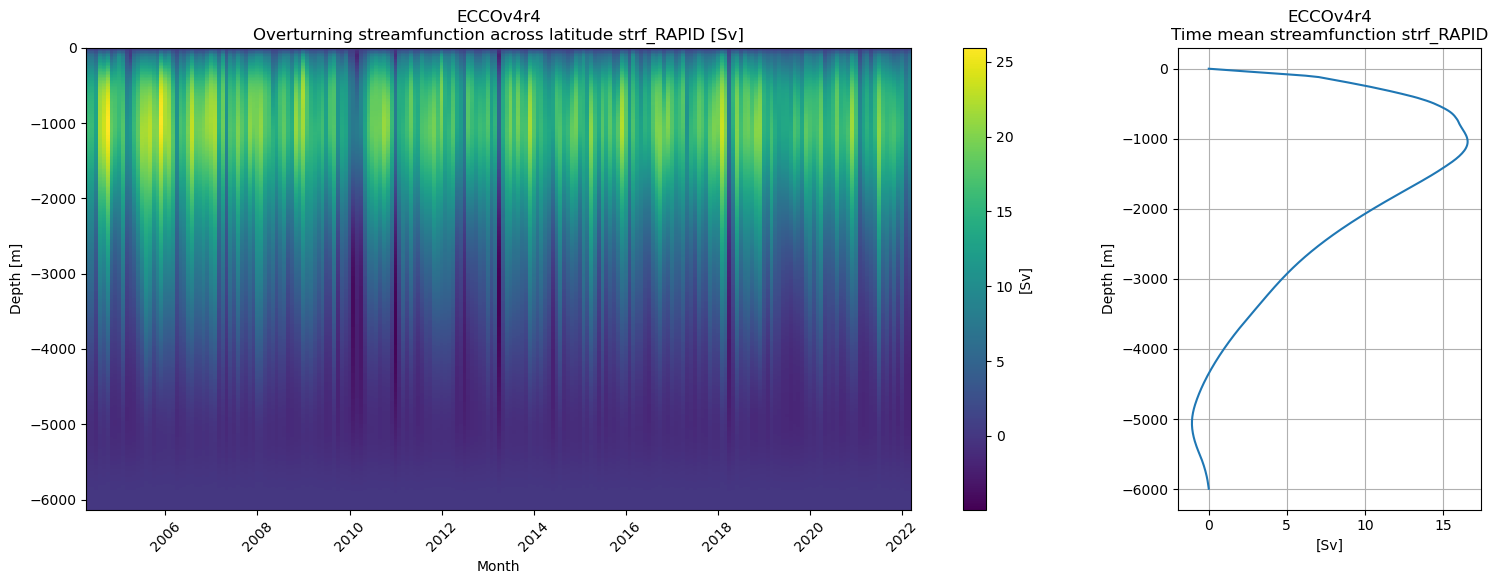

In [364]:
RAPID_path = os.path.join(paths.RAPID_ARRAY, "moc_vertical.nc")

# Resample to monthly mean values
PSI_RAPID = format_RAPID(RAPID_path).resample(time='1ME').mean()

RAPID_inputs = strf_utils.get_PSI_at_max_density_level(
                    PSI_RAPID, moc_param='psi_moc', max=True
                ).drop_vars('Z')

strf_utils.plot_depth_stf_vs_time(stf_ds=PSI_RAPID.squeeze(), label='strf_RAPID', param='psi_moc')

2. Get the Input Surface variables at 30S for the atlantic basin

In [365]:
lat = lats[1]
lat_str = strf_utils.format_lat_lon(lat)

lon_min = -50
lon_max = 17

inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{lat_str}.nc").isel(latitude=slice(1,2))
inputs = inputs.sel(longitude=slice(lon_min, lon_max))
inputs

<xarray.Dataset>
Dimensions:    (time: 312, latitude: 1, longitude: 134)
Coordinates:
  * latitude   (latitude) float32 -29.75
  * longitude  (longitude) float32 -49.75 -49.25 -48.75 ... 15.75 16.25 16.75
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 ...
    ZWS        (time, latitude, longitude) float32 ...
    OBP        (time, latitude, longitude) float32 ...
    SSS        (time, latitude, longitude) float32 ...
    SST        (time, latitude, longitude) float32 ...

3. Retrieve the 30S depth streamfunctions for the upper and lower cell

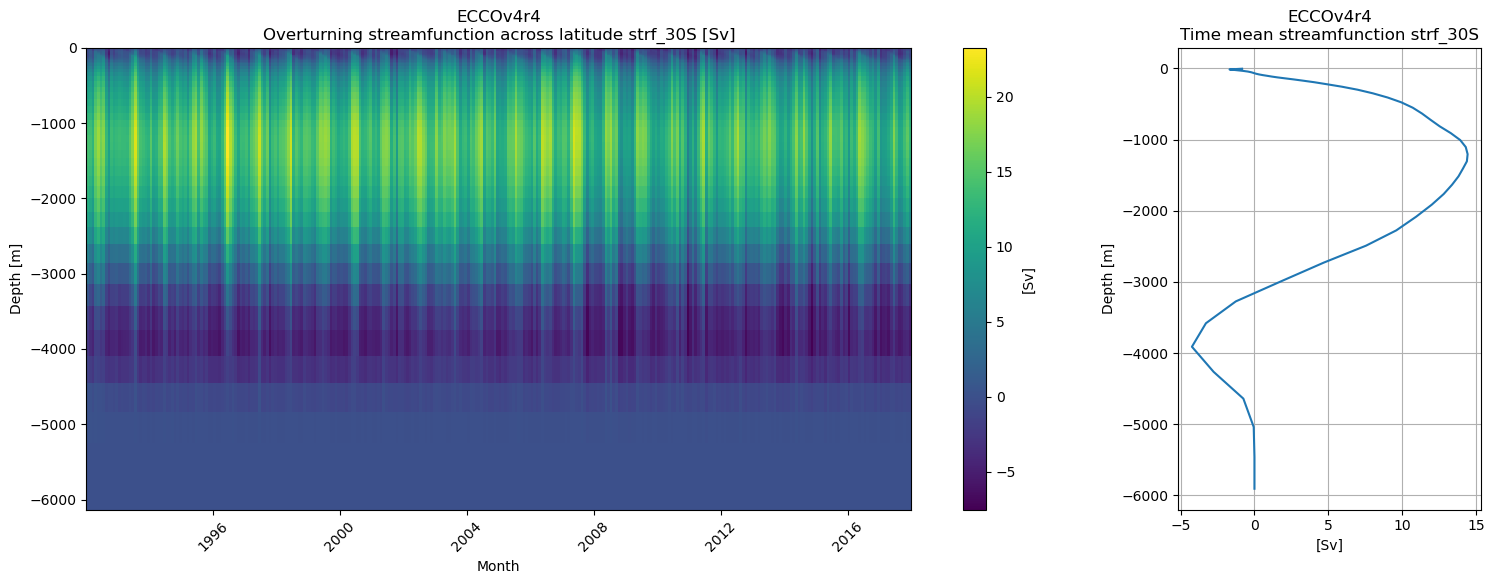

In [368]:
extra_str = 'atlantic_sf'
strf_fp = f"{data_home}/ecco_data_minimal/{lat_str}_{extra_str}_depth.pickle"
depth_fp = f"{data_home}/ecco_data_minimal/depth_range.pickle"
ECCO_GRID = xr.open_dataset(paths.geom_fp)

with open(strf_fp, 'rb') as f:
    strf = pickle.load(f).astype(np.float64)[::-1] #Load the streamfunction and invert the depth values

strf = np.expand_dims(strf[:, 1, :], 1) # grabbing just 30S
strf = np.transpose(strf, (2,0,1))
    
strf = xr.Dataset(
        data_vars = {'moc' : (["time", "k", "latitude"], strf)}, 
        coords = {'time' : inputs.time,  'k': np.arange(50), 'latitude' : np.atleast_1d(-60)}
        )

strf = strf.assign_coords(Z=('k', ECCO_GRID.coords['Z'].data))

outputs_upper_cell = strf_utils.get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=True)
outputs_bottom_cell = strf_utils.get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=False)

strf_utils.plot_depth_stf_vs_time(stf_ds=strf.squeeze(), label='strf_30S', param='moc')

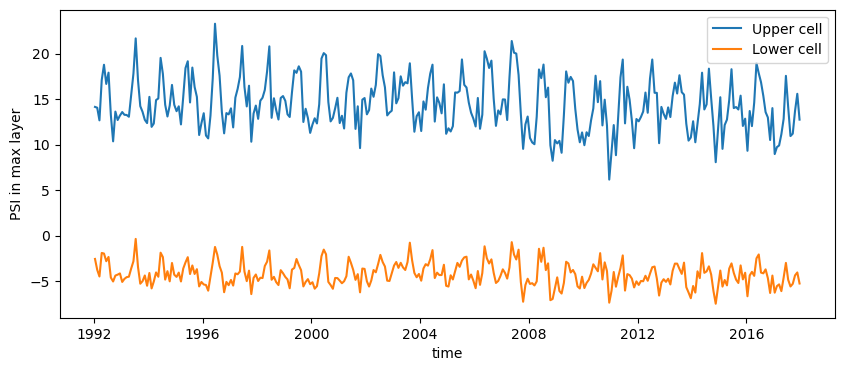

In [370]:
# Plot both streamfunctions for a sanity check

plt.figure(figsize = (10, 4))
plt.plot(outputs_upper_cell["time"].squeeze(), outputs_upper_cell["moc"].squeeze(), label='Upper cell')   
plt.plot(outputs_bottom_cell["time"].squeeze(), outputs_bottom_cell["moc"].squeeze(), label='Lower cell') 
plt.xlabel('time')
plt.ylabel('PSI in max layer')
plt.legend()

#### B. Align the data inputs

In [371]:
# Decide which of the streamfunctions at 30S to predict
outputs = outputs_upper_cell

In [372]:
# RAPID has the latest start date and the ECCO data has the earliest end date (combine)
date_range = (RAPID_inputs.time.values[0], inputs.time.values[-1]) 
date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
print('Date range to align to:', date_range)

# Align the surface variable inputs with RAPID, then align the in- and outputs
inputs, RAPID_inputs = align_inputs_outputs(inputs, RAPID_inputs, date_range = date_range, ecco=False)
inputs, outputs = align_inputs_outputs(inputs, outputs, date_range = date_range, ecco=False)

Date range to align to: ('2004-04-30', '2017-12-16')


In [385]:
# Apply standardization to both RAPID and surface data (can't be done together as the longitude dimension still differs in both)
pp_data_RAPID = apply_preprocessing(RAPID_inputs,
                                    mode="inputs",
                                    remove_season=False,
                                    remove_trend=False,
                                    standardize=True,
                                    lowpass=False)

pp_data_surface = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=False,
                              remove_trend=False,
                              standardize=True,
                              lowpass=False)

# reshape as desired and convert to a numpy array
pp_data_RAPID_np = reshape_inputs(pp_data_RAPID, history=6, keep_coords=["time"], data_vars=["psi_moc"])
pp_data_SURFACE_np = reshape_inputs(pp_data_surface, history=6, keep_coords=["time"], data_vars=["SSH", "SSS", "OBP", "ZWS"])

# Concatenate the different information layers together
pp_data_np = np.concatenate((pp_data_RAPID_np, pp_data_SURFACE_np), axis=-1)
#pp_data_np = pp_data_RAPID_np
X = pp_data_np

axes: ['time', 'history', 'feature']
variables: ['psi_moc']
shape: (159, 6, 1)
axes: ['time', 'history', 'feature']
variables: ['SSH', 'SSS', 'OBP', 'ZWS']
shape: (159, 6, 4)


In [386]:
# MOC strength preprocessing
strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=False,
                               remove_trend=False,
                               standardize=False,
                               lowpass=False)
strength_np = strength.moc.squeeze().values
    
# Necessary step to do convolutions along the right axis with pytorch tensors!
dims = list(range(X.ndim))  
dims[1], dims[-1] = dims[-1], dims[1]
X = np.transpose(X, dims)

conv_dims = 1
if len(X.shape) == (conv_dims + 1):
    X = np.expand_dims(X, axis=-1)

y = strength_np[-X.shape[0]:]

print()
print('Inputs shape:', X.shape)
print('Outputs shape:', y.shape)


Inputs shape: (159, 5, 6)
Outputs shape: (159,)


#### C. Define train (validation) and test sets and perform training

In [387]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, stratify=None, random_state=123456)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=False, stratify=None, random_state=123456)

device = "cuda" if t.cuda.is_available() else "cpu"
print(f"device: {device}")

Xt_train = t.tensor(X_train, device=device).double()
Yt_train = t.tensor(y_train, device=device).double()
Xt_valid = t.tensor(X_valid, device=device).double()
Yt_valid = t.tensor(y_valid, device=device).double()
Xt_test = t.tensor(X_test, device=device).double()
Yt_test = t.tensor(y_test, device=device).double()

device: cpu


In [388]:
import importlib
from models import train, SimDataset, CNN1D, CNN2D, CNN3D

importlib.reload(train)
importlib.reload(CNN1D)
importlib.reload(CNN2D)
importlib.reload(SimDataset)

<module 'models.SimDataset' from 'C:\\Users\\aline\\OTP\\models\\SimDataset.py'>

device: cpu
4691 parameters.


100%|██████████| 2500/2500 [00:16<00:00, 153.22it/s]


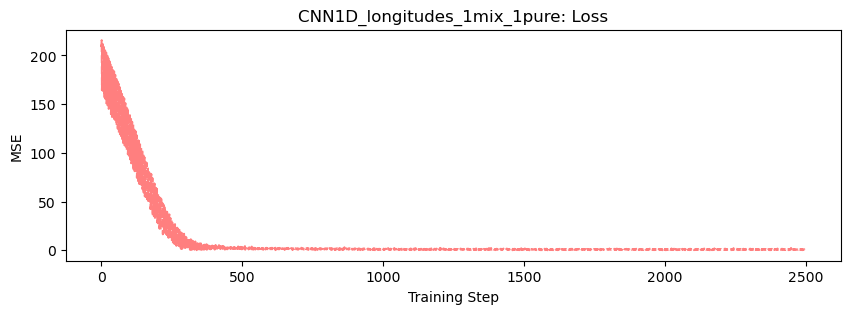

final loss: 0.28688670947749856
model saved to H:/.shortcut-targets-by-id/1wvJjD0RMTujKYaXQapEiGk-Mx03_KSin/GTC\ecco_models/saved_models/CNN1D_longitudes_1mix_1pure.pt
loss curve saved to H:/.shortcut-targets-by-id/1wvJjD0RMTujKYaXQapEiGk-Mx03_KSin/GTC\ecco_models/loss_curves/CNN1D_longitudes_1mix_1pure.png


In [389]:
dropout = 0.2
n_pure_layers = 1
n_mix_layers = 2
n_features = 5
n_channels = n_features * 7
kernel_size = 3

model = CNN1D.CNN1D(
    n_pure_layers=n_pure_layers, 
    n_mix_layers=n_mix_layers, 
    n_features=n_features, 
    n_channels=n_channels,
    kernel_size=kernel_size,
    dropout=dropout
).double()

save_dir = paths.MODELS_OUTPUT
loss1 = train.train_model(model, 'CNN1D_longitudes_1mix_1pure', Xt_train, Yt_train, Xt_valid ,Yt_valid, val_interval=500, save_dir=save_dir)

device: cpu
device: cpu
device: cpu
Test R^2: 0.143
Test MSE: 5.324
Test RMSE: 2.307
Test MAE: 1.942
Test MAPE: 0.132


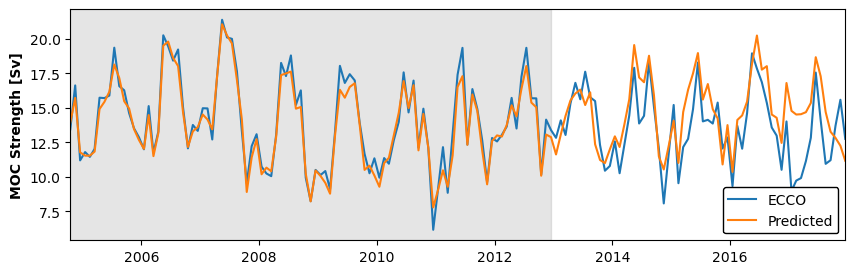

In [390]:
# Extracting all predictions in time order
train_set_pred = train.predict(model, 'CNN1D', Xt_train, Yt_train, save_dir=save_dir)
valid_set_pred = train.predict(model, 'CNN1D', Xt_valid, Yt_valid, save_dir=save_dir)
test_set_pred = train.predict(model, 'CNN1D', Xt_test, Yt_test, save_dir=save_dir)
all_preds = np.concatenate([train_set_pred, valid_set_pred, test_set_pred])

r2 = round(r2_score(test_set_pred, y_test), 3)
mse = round(mean_squared_error(test_set_pred, y_test), 3)
rmse = round(root_mean_squared_error(test_set_pred, y_test), 3)
mae = round(mean_absolute_error(test_set_pred, y_test), 3)
mape = round(mean_absolute_percentage_error(test_set_pred, y_test), 3)

print(f"Test R^2: {r2}")
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test MAPE: {mape}")

time = outputs.time.values[-X.shape[0]:]

fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
plt.show()

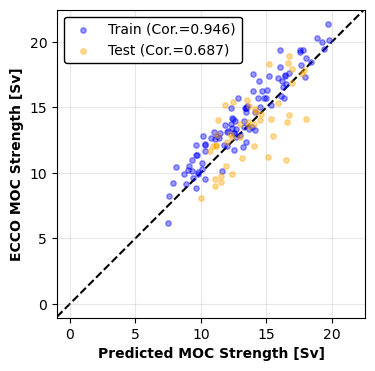

In [322]:
# Alternate view: looking at a scatterplot of predicted vs. actual
y_pred_train = np.array(train_set_pred).squeeze()
y_pred_test = np.array(test_set_pred).squeeze()

fig, ax = pred_vs_actual(y_pred_train, y_pred_test, y_train, y_test)
plt.show()